# 1 Анализ данных и выдвижение гипотез

## 1.1 Подготовка данных

In [ ]:
!wget https://davmedia.cups.online/tasks/round_783/task_1513/a326862555bdf9a45f84df3fb75b0624  -o sample_submission.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import random

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(42) # Установка общего seed для повторяемости экспериментов

In [ ]:
data_config = {
    "train_path": "/content/drive/MyDrive/AIChallenge/train",
    "test_path": "/content/drive/MyDrive/AIChallenge/test",
}

In [ ]:
train_meta = pd.read_csv(f"{data_config['train_path']}/train_meta.csv")
gts = pd.read_csv(f"{data_config['train_path']}/train_gts.csv")

test_meta = pd.read_csv(f"{data_config['test_path']}/test_meta.csv")

## 1.2 Визуализация

### 1.2.1 Визуализация данных ЭКГ

In [ ]:
import plotly
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline


def visualise(data: np.array, start: int = 0, end: int = None) -> None:
  """
  Функция визуализации ЭКГ

  :param data: данные для визуализации
  :param start: стартовая трасса для отображения из данных
  :param end: последняя трасса для отображения из данных
  """

  fig = go.Figure()
  if end is None:
    end = data.shape[0]

  for i in range(start, end):
    fig.add_trace(go.Scatter(x=np.array(range(5000)), y=data[i]))

  fig.show()

Визуализируем для примера два ЭКГ. Больного и здорового человека

In [ ]:
with open(f"{data_config['train_path']}/{gts[gts['myocard'] == 0].iloc[0]['record_name']}.npy", 'rb') as file:
  visualise(np.load(file, allow_pickle=True))

In [ ]:
with open(f"{data_config['train_path']}/{gts[gts['myocard'] == 1].iloc[0]['record_name']}.npy", 'rb') as file:
  visualise(np.load(file, allow_pickle=True))

На графике больного заметно отклонение по некоторым трассам. Данное замечание будет использованно нами позже(пункт 2.2.3)

### 1.2.2 Визуализация отношения классов

In [ ]:
sns.set_style('darkgrid')

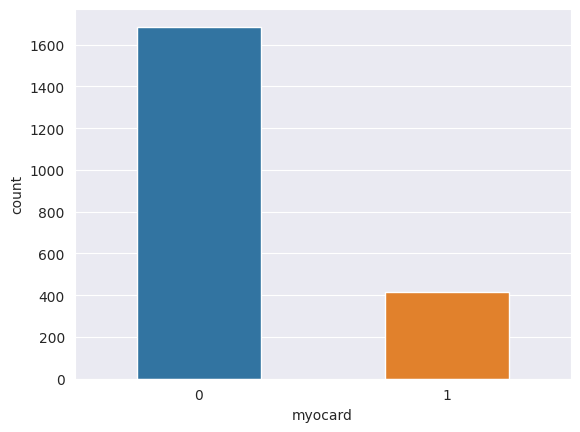

In [ ]:
plot = sns.barplot(gts['myocard'].value_counts().reset_index(),
                   x='index', y='myocard', width=0.5).set(xlabel='myocard', ylabel='count')

Заметен явный дисбаланс классов в сторону метки "0"(отсутствие заболевания), поэтому мы попробовали применить аугментации к данным. Результаты эксперимента в пункте 2.1.2

## 1.2 Выделение разных типов признаков

In [ ]:
gts = train_meta.merge(gts, on='record_name')

### 1.2.1 Пропуски в данных

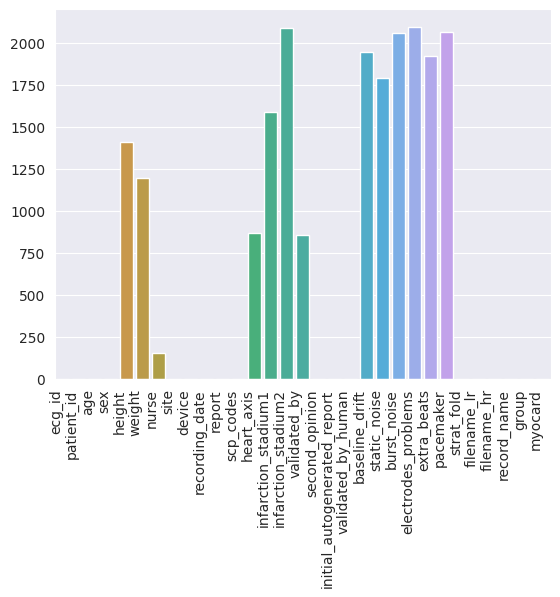

In [ ]:

bar_barris = sns.barplot(x=gts.columns, y=np.sum(gts.isna(), axis=0))
bar_barris = bar_barris.set_xticklabels(bar_barris.get_xticklabels(),
                                        rotation=90, ha="right")

In [ ]:
gts.fillna(0, inplace=True)

### 1.2.2 Категориальные признаки

In [ ]:
cl = []
for c in sorted(gts.columns, key=lambda c: len(gts[c].unique())):
    print(c, len(gts[c].unique()))

sex 2
second_opinion 2
initial_autogenerated_report 2
validated_by_human 2
myocard 2
pacemaker 3
group 3
infarction_stadium2 4
electrodes_problems 5
infarction_stadium1 7
heart_axis 9
validated_by 10
strat_fold 10
device 11
nurse 12
burst_noise 24
extra_beats 30
site 38
static_noise 42
height 52
baseline_drift 72
age 79
weight 80
scp_codes 802
report 1242
patient_id 2066
ecg_id 2101
recording_date 2101
filename_lr 2101
filename_hr 2101
record_name 2101


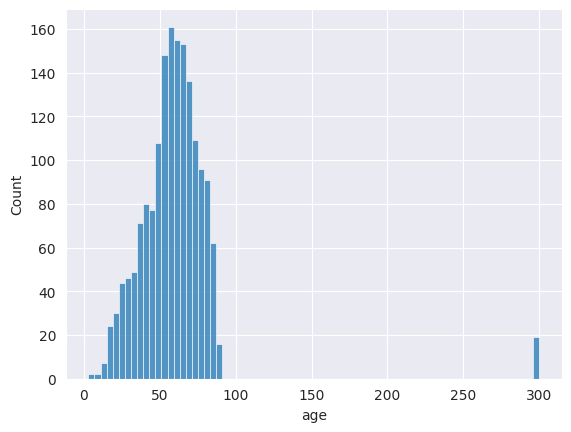

In [ ]:
p = sns.histplot(gts[gts['myocard']==0]['age'])

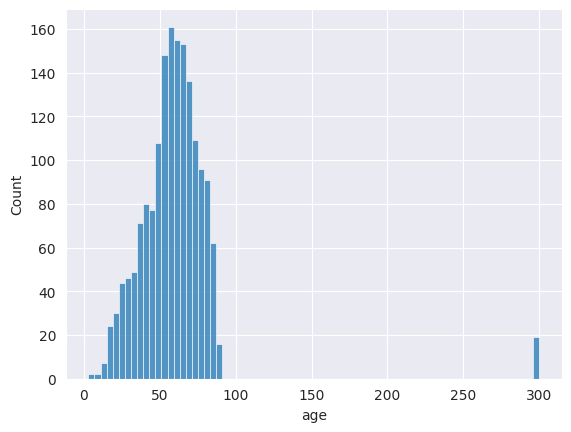

In [ ]:
p = sns.histplot(gts[gts['myocard']==0]['age'])

In [ ]:
print(max(gts['age']), min(gts['age']), np.mean(gts['age']))

300.0 3.0 62.58115183246073


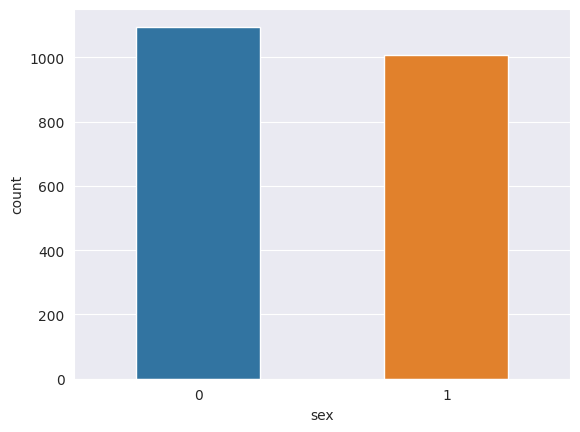

In [ ]:
p= sns.barplot(gts['sex'].value_counts().reset_index(),
            x='index', y='sex', width=0.5).set(xlabel='sex', ylabel='count')

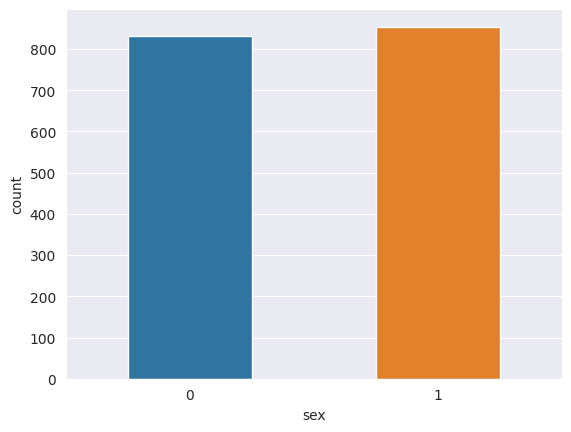

In [ ]:
p = sns.barplot(gts[gts['myocard']==0]['sex'].value_counts().reset_index(),
            x='index', y='sex', width=0.5).set(xlabel='sex', ylabel='count')

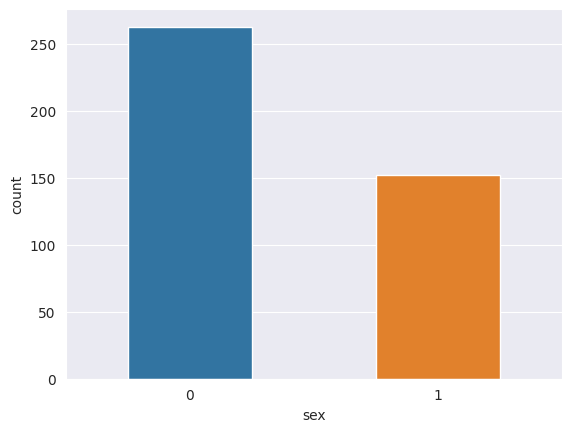

In [ ]:
p = sns.barplot(gts[gts['myocard']==1]['sex'].value_counts().reset_index(),
                x='index', y='sex', width=0.5).set(xlabel='sex', ylabel='count')

### 1.2.3 Текстовые признаки

Сказать, почему мы их обрабатываем как текст

In [ ]:
gts['report']

0                              sinusrhythmus normales ekg
1       erneut vorhofflattern unter 3x1 cordichin ,1x0...
2                              sinusrhythmus normales ekg
3       sinusrhythmus unvollstÄndiger rechtsschenkelbl...
4                              sinusrhythmus normales ekg
                              ...                        
2096    sinusrhythmus p-sinistrocardiale lagetyp norma...
2097    sinusrhythmus lagetyp normal normales ekg 4.46...
2098    sinusrhythmus lagetyp normal normales ekg 4.46...
2099    sinusrhythmus lagetyp normal normales ekg 4.46...
2100    sinusrhythmus lagetyp normal qrs(t) abnorm    ...
Name: report, Length: 2101, dtype: object

In [ ]:
gts['scp_codes']

0                              {'NORM': 100.0, 'SR': 0.0}
1                                         {'AFLT': 100.0}
2                              {'NORM': 100.0, 'SR': 0.0}
3                             {'IRBBB': 100.0, 'SR': 0.0}
4                              {'NORM': 100.0, 'SR': 0.0}
                              ...                        
2096    {'IMI': 100.0, 'NDT': 100.0, '1AVB': 100.0, 'A...
2097                           {'NORM': 100.0, 'SR': 0.0}
2098                           {'NORM': 100.0, 'SR': 0.0}
2099                           {'NORM': 100.0, 'SR': 0.0}
2100             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
Name: scp_codes, Length: 2101, dtype: object

# 2 Рассматриваемые решения

## 2.1 Решения только по данным ЭКГ

In [ ]:
!pip install wandb
!pip install transformers
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=09b555f68320b37d074e42cc01c3c6d5dea6311893267c3e27e801829fb8fb96
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

### 2.1.1 ConvNetQuake

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm
import wandb
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from transformers import Adafactor
from torch import optim
import torch_optimizer


gts = pd.read_csv(f"{data_config['train_path']}/train_gts.csv")
meta = pd.read_csv(f"{data_config['train_path']}/train_meta.csv")
os.mkdir('models')

class FullNormalNoise():
  """Наложение случайного нормального распределения на график"""

  def __init__(self, mean: int = 0, sigma: int = 0.01):
    self.mean = mean
    self.sigma = sigma

  def __call__(self, data: np.array) -> np.array:
    noise = np.random.normal(self.mean, self.sigma, data.shape[-1])
    return data + noise

class RandomPartNormalNoise():
  """Наложение случайного нормального распределения заданной длины в случайном месте на графике"""

  def __init__(self, mean: int = 0, sigma: int = 0.01, length: int = 1000):
    self.mean = mean
    self.sigma = sigma
    self.length = length

  def __call__(self, data: np.array) -> np.array:
    noise = np.random.normal(self.mean, self.sigma, self.length)
    start_point = random.randint(0, data.shape[-1]-self.length)
    prefix = np.zeros((start_point))
    suffix = np.zeros((data.shape[-1] - (start_point+self.length)))
    noise = np.concatenate((prefix, noise, suffix))

    return data + noise


class ECGDataSet(Dataset):
  """Класс DataSet для выдачи ЭКГ и меток, с применением аугментаций"""

  def __init__(self, meta: list, labels: list=[], ecg: dict=dict(), augmentations: list=[], p:float=0.2):
    self.ecg = ecg
    self.meta = meta
    self.augmentations = augmentations
    self.labels = labels
    self.p = p

  def __len__(self):
    return len(self.meta)

  def __getitem__(self, index):
    record = self.ecg[self.meta[index]]

    if not self.augmentations is None:
      if random.random() <= self.p:
        for aug in self.augmentations:
          record = aug(record)

    if not self.labels is None:
      return torch.Tensor(record), self.labels[index]

    else:
      return torch.Tensor(record), -1

In [ ]:
def validation(model, val_loader, criterion, device, output_type, wandb_log=False):
    with torch.no_grad():
        model.eval()
        y_true = []
        y_pred = []
        m_loss = []
        with tqdm(total=len(val_loader)) as tq:
            for batch in val_loader:
                x, y = batch
                pred = model(x.to(device).float())
                if output_type == 'sigmoid':
                    loss = criterion(pred.float(), y.to(device).unsqueeze(-1).float())
                    y_pred.append(pred.float().cpu().numpy())
                elif output_type == 'softmax':
                    loss = criterion(pred.float(), y.to(device))
                    y_pred.append(torch.argmax(pred, dim=-1).float().cpu().numpy())
                elif output_type == 'softmax_bce':
                    loss = criterion(pred.float(), torch.nn.functional.one_hot(y.to(device), num_classes=2).float())
                    y_pred.append(torch.argmax(pred, dim=-1).float().cpu().numpy())
                else:
                    raise ValueError
                m_loss.append(loss.item())
                tq.set_description(str(np.mean(m_loss)), refresh=True)
                y_true.append(y.cpu().numpy())

                if wandb_log:
                    wandb.log({'Val Loss': loss.item(), 'Val Mean Loss': np.mean(m_loss)})
                tq.update()
        y_true = np.concatenate(y_true)
        y_pred = np.round(np.concatenate(y_pred))
        model.train()
    return f1_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred)


def train(model, optimizer, criterion, train_loader, val_loader, device, epochs=1000,
          output_type='sigmoid', scheduler=None, path='models/ConvNet/', wandb_log=False):
    model.to(device)
    best_f1 = 0
    for epoch in range(epochs):
        with tqdm(total=len(train_loader)) as tq:
            m_loss = []
            for batch in train_loader:
                x, y = batch

                pred = model(x.to(device).float())
                if output_type == 'sigmoid':
                    loss = criterion(pred.float(), y.unsqueeze(1).to(device).float())
                elif output_type == 'softmax':
                    loss = criterion(pred, y.to(device))
                elif output_type == 'softmax_bce':
                    loss = criterion(pred.float(), torch.nn.functional.one_hot(y.to(device), num_classes=2).float())
                else:
                    raise ValueError
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                m_loss.append(loss.item())
                if wandb_log:
                    wandb.log({'Loss': loss.item(), 'Mean Loss': np.mean(m_loss)})
                tq.set_description(str(np.mean(m_loss)), refresh=True)
                tq.update()
        f1, precision, recall = validation(model, val_loader, criterion, device, output_type=output_type, wandb_log=wandb_log)
        if wandb_log:
            wandb.log({'F1': f1, "Precision": precision, "Recall": recall})
        if scheduler:
            scheduler.step(f1)
        if f1 > best_f1:
            best_f1 = f1
            checkpoint(model, epoch, f1, path)
        print('Epoch:', epoch, 'F1:', f1, "Precision:", precision, "Recall:", recall, 'Best F1', best_f1)
    return best_f1


def predict(model, test_loader, device):
    with torch.no_grad():
        model.to(device)
        model.eval()
        y_pred = []
        with tqdm(total=len(test_loader)) as tq:
            for batch in test_loader:
                x, y = batch
                pred = model(x.to(device).float())
                y_pred.append(pred.cpu().numpy())
                tq.update()
        y_pred = np.round(np.concatenate(y_pred))
    return y_pred


def checkpoint(model, epoch, metric, path='models/ConvNet/'):
    if not os.path.isdir(path):
        os.mkdir(path)
    torch.save(model.state_dict(), f'{path}{epoch}_{metric}.pt')
    return True


def load_best_model(model, path='models/ConvNet/'):
    models = sorted(os.listdir(path), key=lambda x: float(x.split('_')[0]))
    print(path + models[-1])
    model.load_state_dict(torch.load(path + models[-1]))
    model.eval()
    return model


In [ ]:
class ConvNetQuake(nn.Module):
    def __init__(self):
        super(ConvNetQuake, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.linear1 = nn.Linear(640, 128)
        self.linear2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.bn5 = nn.BatchNorm1d(32)
        self.bn6 = nn.BatchNorm1d(32)
        self.bn7 = nn.BatchNorm1d(32)
        self.bn8 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.bn7(F.relu(self.conv7(x)))
        x = self.bn8(F.relu(self.conv8(x)))
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [ ]:
Config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'test_size': 0.25,
    'seed': 42,
    'batch_size': 42,
    "output_type": 'sigmoid',
    "epochs": 20,
    'lr': 0.05,
    'optimizer': 'Lamb'
}

In [ ]:
gts = pd.read_csv(f"{data_config['train_path']}/train_gts.csv")
wandb_log = False
ecg = {}

for file_name in os.listdir(data_config['train_path']):
    file_path = os.path.join(data_config['train_path'], file_name)
    if os.path.isfile(file_path) and ".npy" in file_name:
        with open(file_path, "rb") as f:
          ecg[file_name.replace(".npy", "")] = np.load(f, allow_pickle=True)

X = gts['record_name'].tolist()
y = gts['myocard'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Config['test_size'], random_state=Config['seed'])

In [ ]:
dataset_train = ECGDataSet(X_train, y_train, ecg, p=0)
dataset_val = ECGDataSet(X_test, y_test, ecg, p=0)
train_loader = DataLoader(dataset_train, batch_size=Config["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=Config["batch_size"], shuffle=False)

In [ ]:
model = ConvNetQuake()
device = torch.device(Config['device'])
if Config['output_type'] == 'softmax':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.CrossEntropyLoss()
elif Config['output_type'] == 'softmax_bce':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.BCELoss()
elif Config['output_type'] == 'sigmoid':
    criterion = nn.BCELoss()

if Config['optimizer'] == 'AdamW':
     optimizer = optim.AdamW(model.parameters(), lr=Config['lr'])
elif Config['optimizer'] == 'Adafactor':
    optimizer = Adafactor(model.parameters(), lr=Config['lr'], scale_parameter=False, relative_step=False)
elif Config['optimizer'] == 'Lamb':
    optimizer = torch_optimizer.Lamb(model.parameters(), lr=Config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=12, verbose=True)
Config['scheduler']  = str(scheduler).split('.')[-1].split()[0]
Config['optimizer'] = str(optimizer)


print(train(model, optimizer, criterion, train_loader, val_loader, device,
  epochs=Config['epochs'], output_type=Config['output_type'], scheduler=scheduler, wandb_log=wandb_log))

3.962698771403386: 100%|██████████| 13/13 [00:00<00:00, 98.34it/s] 


Epoch: 0 F1: 0.33548387096774196 Precision: 0.48148148148148145 Recall: 0.25742574257425743 Best F1 0.33548387096774196


0.5865169305067796: 100%|██████████| 13/13 [00:00<00:00, 81.40it/s]


Epoch: 1 F1: 0.0 Precision: 0.0 Recall: 0.0 Best F1 0.33548387096774196


0.5408895611763: 100%|██████████| 13/13 [00:00<00:00, 65.04it/s]


Epoch: 2 F1: 0.05714285714285714 Precision: 0.75 Recall: 0.0297029702970297 Best F1 0.33548387096774196


0.7491166431170243: 100%|██████████| 13/13 [00:00<00:00, 102.55it/s]


Epoch: 3 F1: 0.0 Precision: 0.0 Recall: 0.0 Best F1 0.33548387096774196


0.42423199919553906: 100%|██████████| 13/13 [00:00<00:00, 89.37it/s]


Epoch: 4 F1: 0.5316455696202531 Precision: 0.7368421052631579 Recall: 0.4158415841584158 Best F1 0.5316455696202531


0.4728153565755257: 100%|██████████| 13/13 [00:00<00:00, 59.09it/s]


Epoch: 5 F1: 0.37241379310344824 Precision: 0.6136363636363636 Recall: 0.26732673267326734 Best F1 0.5316455696202531


0.4250216403832802: 100%|██████████| 13/13 [00:00<00:00, 60.79it/s]


Epoch: 6 F1: 0.6421052631578947 Precision: 0.6853932584269663 Recall: 0.6039603960396039 Best F1 0.6421052631578947


0.5699325272670159: 100%|██████████| 13/13 [00:00<00:00, 57.74it/s]


Epoch: 7 F1: 0.1754385964912281 Precision: 0.7692307692307693 Recall: 0.09900990099009901 Best F1 0.6421052631578947


0.416826925598658: 100%|██████████| 13/13 [00:00<00:00, 71.15it/s]


Epoch: 8 F1: 0.46715328467153283 Precision: 0.8888888888888888 Recall: 0.31683168316831684 Best F1 0.6421052631578947


0.3873290717601776: 100%|██████████| 13/13 [00:00<00:00, 85.18it/s]


Epoch: 9 F1: 0.3636363636363636 Precision: 0.7741935483870968 Recall: 0.2376237623762376 Best F1 0.6421052631578947


0.2898815239851291: 100%|██████████| 13/13 [00:00<00:00, 85.43it/s]


Epoch: 10 F1: 0.6842105263157896 Precision: 0.7303370786516854 Recall: 0.6435643564356436 Best F1 0.6842105263157896


0.4221207866301903: 100%|██████████| 13/13 [00:00<00:00, 75.53it/s]


Epoch: 11 F1: 0.6229508196721312 Precision: 0.5314685314685315 Recall: 0.7524752475247525 Best F1 0.6842105263157896


0.510581944997494: 100%|██████████| 13/13 [00:00<00:00, 84.04it/s]


Epoch: 12 F1: 0.4895104895104895 Precision: 0.8333333333333334 Recall: 0.3465346534653465 Best F1 0.6842105263157896


0.39142304544265455: 100%|██████████| 13/13 [00:00<00:00, 82.15it/s]


Epoch: 13 F1: 0.6494845360824741 Precision: 0.6774193548387096 Recall: 0.6237623762376238 Best F1 0.6842105263157896


0.2909732988247505: 100%|██████████| 13/13 [00:00<00:00, 87.33it/s]


Epoch: 14 F1: 0.6559139784946236 Precision: 0.7176470588235294 Recall: 0.6039603960396039 Best F1 0.6842105263157896


0.8720294970732468: 100%|██████████| 13/13 [00:00<00:00, 97.23it/s]


Epoch: 15 F1: 0.5502958579881656 Precision: 0.3924050632911392 Recall: 0.9207920792079208 Best F1 0.6842105263157896


0.3541428240445944: 100%|██████████| 13/13 [00:00<00:00, 101.34it/s]


Epoch: 16 F1: 0.5599999999999999 Precision: 0.8571428571428571 Recall: 0.4158415841584158 Best F1 0.6842105263157896


0.34141910993135893: 100%|██████████| 13/13 [00:00<00:00, 73.25it/s]


Epoch: 17 F1: 0.6063829787234043 Precision: 0.6551724137931034 Recall: 0.5643564356435643 Best F1 0.6842105263157896


0.33133157056111556: 100%|██████████| 13/13 [00:00<00:00, 68.74it/s]


Epoch: 18 F1: 0.6363636363636364 Precision: 0.6494845360824743 Recall: 0.6237623762376238 Best F1 0.6842105263157896


0.3968741297721863: 100%|██████████| 13/13 [00:00<00:00, 69.78it/s]


Epoch: 19 F1: 0.6562500000000001 Precision: 0.6923076923076923 Recall: 0.6237623762376238 Best F1 0.6842105263157896
0.6842105263157896


### 2.1.2 ConvNetQuake + Augmentation

In [ ]:
dataset_train = ECGDataSet(X_train, labels=y_train, augmentations=[RandomPartNormalNoise(), FullNormalNoise()], ecg=ecg, p=0.2)
dataset_val = ECGDataSet(X_test, labels=y_test, ecg=ecg, p=0.2)
train_loader = DataLoader(dataset_train, batch_size=Config["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=Config["batch_size"], shuffle=False)

In [ ]:
model = ConvNetQuake()
device = torch.device(Config['device'])
if Config['output_type'] == 'softmax':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.CrossEntropyLoss()
elif Config['output_type'] == 'softmax_bce':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.BCELoss()
elif Config['output_type'] == 'sigmoid':
    criterion = nn.BCELoss()

if Config['optimizer'] == 'AdamW':
     optimizer = optim.AdamW(model.parameters(), lr=Config['lr'])
elif Config['optimizer'] == 'Adafactor':
    optimizer = Adafactor(model.parameters(), lr=Config['lr'], scale_parameter=False, relative_step=False)
elif Config['optimizer'] == 'Lamb':
    optimizer = torch_optimizer.Lamb(model.parameters(), lr=Config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=12, verbose=True)
Config['scheduler']  = str(scheduler).split('.')[-1].split()[0]
Config['optimizer'] = str(optimizer)
for i in os.listdir('models/ConvNet'):
        os.remove(f'models/ConvNet/{i}')
print(train(model, optimizer, criterion, train_loader, val_loader, device,
  epochs=Config['epochs'], output_type=Config['output_type'], scheduler=scheduler, wandb_log=wandb_log))

0.6691485001490667: 100%|██████████| 13/13 [00:00<00:00, 72.60it/s]


Epoch: 0 F1: 0.14084507042253522 Precision: 0.13392857142857142 Recall: 0.1485148514851485 Best F1 0.14084507042253522


0.697361212510329: 100%|██████████| 13/13 [00:00<00:00, 102.07it/s]


Epoch: 1 F1: 0.28318584070796465 Precision: 0.20168067226890757 Recall: 0.4752475247524752 Best F1 0.28318584070796465


0.7055925681040838: 100%|██████████| 13/13 [00:00<00:00, 92.74it/s]


Epoch: 2 F1: 0.27472527472527475 Precision: 0.19011406844106463 Recall: 0.49504950495049505 Best F1 0.28318584070796465


0.7032442367993869: 100%|██████████| 13/13 [00:00<00:00, 88.14it/s]


Epoch: 3 F1: 0.2768361581920904 Precision: 0.19367588932806323 Recall: 0.48514851485148514 Best F1 0.28318584070796465


0.7048362493515015: 100%|██████████| 13/13 [00:00<00:00, 99.46it/s]


Epoch: 4 F1: 0.2833333333333333 Precision: 0.1969111969111969 Recall: 0.504950495049505 Best F1 0.2833333333333333


0.7012926019155062: 100%|██████████| 13/13 [00:00<00:00, 92.31it/s]


Epoch: 5 F1: 0.26136363636363635 Precision: 0.18326693227091634 Recall: 0.45544554455445546 Best F1 0.2833333333333333


0.7008243845059321: 100%|██████████| 13/13 [00:00<00:00, 95.51it/s]


Epoch: 6 F1: 0.2745098039215686 Precision: 0.19140625 Recall: 0.48514851485148514 Best F1 0.2833333333333333


0.7025024157304031: 100%|██████████| 13/13 [00:00<00:00, 93.81it/s]


Epoch: 7 F1: 0.2704225352112676 Precision: 0.1889763779527559 Recall: 0.4752475247524752 Best F1 0.2833333333333333


0.7021221931164081: 100%|██████████| 13/13 [00:00<00:00, 96.81it/s]


Epoch: 8 F1: 0.28176795580110503 Precision: 0.19540229885057472 Recall: 0.504950495049505 Best F1 0.2833333333333333


0.7023620972266564: 100%|██████████| 13/13 [00:00<00:00, 87.71it/s]


Epoch: 9 F1: 0.2737430167597765 Precision: 0.19066147859922178 Recall: 0.48514851485148514 Best F1 0.2833333333333333


0.7024271854987512: 100%|██████████| 13/13 [00:00<00:00, 94.12it/s]


Epoch: 10 F1: 0.27548209366391185 Precision: 0.19083969465648856 Recall: 0.49504950495049505 Best F1 0.2833333333333333


0.7026814314035269: 100%|██████████| 13/13 [00:00<00:00, 87.07it/s]


Epoch: 11 F1: 0.2880886426592798 Precision: 0.2 Recall: 0.5148514851485149 Best F1 0.2880886426592798


0.703908227957212: 100%|██████████| 13/13 [00:00<00:00, 68.18it/s]


Epoch: 12 F1: 0.2737430167597765 Precision: 0.19066147859922178 Recall: 0.48514851485148514 Best F1 0.2880886426592798


0.7064229937700125: 100%|██████████| 13/13 [00:00<00:00, 76.68it/s]


Epoch: 13 F1: 0.2684931506849315 Precision: 0.1856060606060606 Recall: 0.48514851485148514 Best F1 0.2880886426592798


0.704375161574437: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]


Epoch: 14 F1: 0.2684931506849315 Precision: 0.1856060606060606 Recall: 0.48514851485148514 Best F1 0.2880886426592798


0.7010564162180974: 100%|██████████| 13/13 [00:00<00:00, 72.61it/s]


Epoch: 15 F1: 0.2785515320334262 Precision: 0.1937984496124031 Recall: 0.49504950495049505 Best F1 0.2880886426592798


0.7030059878642743: 100%|██████████| 13/13 [00:00<00:00, 96.42it/s]


Epoch: 16 F1: 0.2696629213483146 Precision: 0.18823529411764706 Recall: 0.4752475247524752 Best F1 0.2880886426592798


0.7024810314178467: 100%|██████████| 13/13 [00:00<00:00, 84.95it/s]


Epoch: 17 F1: 0.2696629213483146 Precision: 0.18823529411764706 Recall: 0.4752475247524752 Best F1 0.2880886426592798


0.7049360825465276: 100%|██████████| 13/13 [00:00<00:00, 97.58it/s]


Epoch: 18 F1: 0.2722222222222222 Precision: 0.1891891891891892 Recall: 0.48514851485148514 Best F1 0.2880886426592798


0.7011269422677847: 100%|██████████| 13/13 [00:00<00:00, 83.63it/s]

Epoch: 19 F1: 0.26404494382022475 Precision: 0.1843137254901961 Recall: 0.46534653465346537 Best F1 0.2880886426592798
0.2880886426592798


### 2.1.3 ConvNetQuake + Псевдоразметка

In [ ]:
dataset_train = ECGDataSet(X_train, y_train, ecg, p=0)
dataset_val = ECGDataSet(X_test, y_test, ecg, p=0)
dataset_ps = ECGDataSet(X, y, ecg, p=0)
train_loader = DataLoader(dataset_train, batch_size=Config["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=Config["batch_size"], shuffle=False)
ps_loader = DataLoader(dataset_train, batch_size=Config["batch_size"], shuffle=False)

In [ ]:
model = ConvNetQuake()
device = torch.device(Config['device'])
if Config['output_type'] == 'softmax':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.CrossEntropyLoss()
elif Config['output_type'] == 'softmax_bce':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.BCELoss()
elif Config['output_type'] == 'sigmoid':
    criterion = nn.BCELoss()

if Config['optimizer'] == 'AdamW':
     optimizer = optim.AdamW(model.parameters(), lr=Config['lr'])
elif Config['optimizer'] == 'Adafactor':
    optimizer = Adafactor(model.parameters(), lr=Config['lr'], scale_parameter=False, relative_step=False)
elif Config['optimizer'] == 'Lamb':
    optimizer = torch_optimizer.Lamb(model.parameters(), lr=Config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=12, verbose=True)
Config['scheduler']  = str(scheduler).split('.')[-1].split()[0]
Config['optimizer'] = str(optimizer)
for i in os.listdir('models/ConvNet'):
        os.remove(f'models/ConvNet/{i}')
print(train(model, optimizer, criterion, train_loader, val_loader, device,
  epochs=Config['epochs'], output_type=Config['output_type'], scheduler=scheduler, wandb_log=wandb_log))

0.7149323866917536: 100%|██████████| 13/13 [00:00<00:00, 98.86it/s]


Epoch: 0 F1: 0.30501089324618735 Precision: 0.19553072625698323 Recall: 0.693069306930693 Best F1 0.30501089324618735


0.7138634232374338: 100%|██████████| 13/13 [00:00<00:00, 100.06it/s]


Epoch: 1 F1: 0.2930591259640103 Precision: 0.19791666666666666 Recall: 0.5643564356435643 Best F1 0.30501089324618735


0.7131911057692307: 100%|██████████| 13/13 [00:00<00:00, 109.89it/s]


Epoch: 2 F1: 0.30848329048843187 Precision: 0.20833333333333334 Recall: 0.594059405940594 Best F1 0.30848329048843187


0.7168571032010592: 100%|██████████| 13/13 [00:00<00:00, 95.30it/s]


Epoch: 3 F1: 0.2936708860759494 Precision: 0.19727891156462585 Recall: 0.5742574257425742 Best F1 0.30848329048843187


0.7141632070908179: 100%|██████████| 13/13 [00:00<00:00, 105.63it/s]


Epoch: 4 F1: 0.3010204081632653 Precision: 0.2027491408934708 Recall: 0.5841584158415841 Best F1 0.30848329048843187


0.7131485984875605: 100%|██████████| 13/13 [00:00<00:00, 105.26it/s]


Epoch: 5 F1: 0.2849740932642487 Precision: 0.19298245614035087 Recall: 0.5445544554455446 Best F1 0.30848329048843187


0.7143384218215942: 100%|██████████| 13/13 [00:00<00:00, 102.25it/s]


Epoch: 6 F1: 0.28717948717948716 Precision: 0.19377162629757785 Recall: 0.5544554455445545 Best F1 0.30848329048843187


0.7129371028680068: 100%|██████████| 13/13 [00:00<00:00, 82.97it/s]


Epoch: 7 F1: 0.3041237113402062 Precision: 0.20557491289198607 Recall: 0.5841584158415841 Best F1 0.30848329048843187


0.7153092255959144: 100%|██████████| 13/13 [00:00<00:00, 88.99it/s]


Epoch: 8 F1: 0.2997416020671834 Precision: 0.20279720279720279 Recall: 0.5742574257425742 Best F1 0.30848329048843187


0.7151804566383362: 100%|██████████| 13/13 [00:00<00:00, 75.77it/s]


Epoch: 9 F1: 0.29230769230769227 Precision: 0.1972318339100346 Recall: 0.5643564356435643 Best F1 0.30848329048843187


0.7118979004713205: 100%|██████████| 13/13 [00:00<00:00, 95.15it/s]


Epoch: 10 F1: 0.31052631578947365 Precision: 0.2114695340501792 Recall: 0.5841584158415841 Best F1 0.31052631578947365


0.7137351540418772: 100%|██████████| 13/13 [00:00<00:00, 68.32it/s]


Epoch: 11 F1: 0.2966751918158567 Precision: 0.2 Recall: 0.5742574257425742 Best F1 0.31052631578947365


0.7137863269219031: 100%|██████████| 13/13 [00:00<00:00, 74.85it/s]


Epoch: 12 F1: 0.31443298969072164 Precision: 0.21254355400696864 Recall: 0.6039603960396039 Best F1 0.31443298969072164


0.7146150423930242: 100%|██████████| 13/13 [00:00<00:00, 67.50it/s]


Epoch: 13 F1: 0.2966751918158567 Precision: 0.2 Recall: 0.5742574257425742 Best F1 0.31443298969072164


0.7112895983916062: 100%|██████████| 13/13 [00:00<00:00, 108.24it/s]


Epoch: 14 F1: 0.2924281984334204 Precision: 0.19858156028368795 Recall: 0.5544554455445545 Best F1 0.31443298969072164


0.7123119097489578: 100%|██████████| 13/13 [00:00<00:00, 84.46it/s]


Epoch: 15 F1: 0.30287206266318534 Precision: 0.20567375886524822 Recall: 0.5742574257425742 Best F1 0.31443298969072164


0.7144028315177331: 100%|██████████| 13/13 [00:00<00:00, 98.26it/s]


Epoch: 16 F1: 0.29842931937172773 Precision: 0.20284697508896798 Recall: 0.5643564356435643 Best F1 0.31443298969072164


0.7115096541551443: 100%|██████████| 13/13 [00:00<00:00, 88.19it/s]


Epoch: 17 F1: 0.3064935064935065 Precision: 0.20774647887323944 Recall: 0.5841584158415841 Best F1 0.31443298969072164


0.7140568357247573: 100%|██████████| 13/13 [00:00<00:00, 110.13it/s]


Epoch: 18 F1: 0.29230769230769227 Precision: 0.1972318339100346 Recall: 0.5643564356435643 Best F1 0.31443298969072164


0.7136158759777362: 100%|██████████| 13/13 [00:00<00:00, 90.16it/s]


Epoch: 19 F1: 0.3041237113402062 Precision: 0.20557491289198607 Recall: 0.5841584158415841 Best F1 0.31443298969072164
0.31443298969072164


In [ ]:
# переопределение данных (псевдоразметка)

dataset_train = ECGDataSet(X_train, predict(load_best_model(model), ps_loader, device).flatten().tolist(), ecg, p=0)
dataset_val = ECGDataSet(X_test, y_test, ecg, p=0)
train_loader = DataLoader(dataset_train, batch_size=Config["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=Config["batch_size"], shuffle=False)

models/ConvNet/12_0.31443298969072164.pt


100%|██████████| 38/38 [00:00<00:00, 143.66it/s]


In [ ]:
model = ConvNetQuake()
device = torch.device(Config['device'])
if Config['output_type'] == 'softmax':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.CrossEntropyLoss()
elif Config['output_type'] == 'softmax_bce':
    model.linear2 = nn.Linear(128, 2)
    model.sigmoid = nn.Softmax(dim=-1)
    criterion = nn.BCELoss()
elif Config['output_type'] == 'sigmoid':
    criterion = nn.BCELoss()

if Config['optimizer'] == 'AdamW':
     optimizer = optim.AdamW(model.parameters(), lr=Config['lr'])
elif Config['optimizer'] == 'Adafactor':
    optimizer = Adafactor(model.parameters(), lr=Config['lr'], scale_parameter=False, relative_step=False)
elif Config['optimizer'] == 'Lamb':
    optimizer = torch_optimizer.Lamb(model.parameters(), lr=Config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=12, verbose=True)
Config['scheduler']  = str(scheduler).split('.')[-1].split()[0]
Config['optimizer'] = str(optimizer)
for i in os.listdir('models/ConvNet'):
        os.remove(f'models/ConvNet/{i}')
print(train(model, optimizer, criterion, train_loader, val_loader, device,
  epochs=Config['epochs'], output_type=Config['output_type'], scheduler=scheduler, wandb_log=wandb_log))

0.7122250520266019: 100%|██████████| 13/13 [00:00<00:00, 105.08it/s]


Epoch: 0 F1: 0.2700228832951945 Precision: 0.17559523809523808 Recall: 0.5841584158415841 Best F1 0.2700228832951945


0.7381933744137104: 100%|██████████| 13/13 [00:00<00:00, 105.36it/s]


Epoch: 1 F1: 0.2927927927927928 Precision: 0.18950437317784258 Recall: 0.6435643564356436 Best F1 0.2927927927927928


0.7444646954536438: 100%|██████████| 13/13 [00:00<00:00, 91.43it/s]


Epoch: 2 F1: 0.3015521064301552 Precision: 0.19428571428571428 Recall: 0.6732673267326733 Best F1 0.3015521064301552


0.7424448682711675: 100%|██████████| 13/13 [00:00<00:00, 85.73it/s]


Epoch: 3 F1: 0.2926829268292683 Precision: 0.18857142857142858 Recall: 0.6534653465346535 Best F1 0.3015521064301552


0.7420843060200031: 100%|██████████| 13/13 [00:00<00:00, 102.54it/s]


Epoch: 4 F1: 0.27334851936218674 Precision: 0.17751479289940827 Recall: 0.594059405940594 Best F1 0.3015521064301552


0.7420148666088398: 100%|██████████| 13/13 [00:00<00:00, 75.33it/s]


Epoch: 5 F1: 0.29464285714285715 Precision: 0.19020172910662825 Recall: 0.6534653465346535 Best F1 0.3015521064301552


0.7434934790317829: 100%|██████████| 13/13 [00:00<00:00, 83.95it/s]


Epoch: 6 F1: 0.3015521064301552 Precision: 0.19428571428571428 Recall: 0.6732673267326733 Best F1 0.3015521064301552


0.7423072136365451: 100%|██████████| 13/13 [00:00<00:00, 95.96it/s]


Epoch: 7 F1: 0.2933333333333334 Precision: 0.18911174785100288 Recall: 0.6534653465346535 Best F1 0.3015521064301552


0.7413231776310847: 100%|██████████| 13/13 [00:00<00:00, 85.10it/s]


Epoch: 8 F1: 0.2979683972911964 Precision: 0.19298245614035087 Recall: 0.6534653465346535 Best F1 0.3015521064301552


0.7446606617707473: 100%|██████████| 13/13 [00:00<00:00, 75.81it/s]


Epoch: 9 F1: 0.2984409799554566 Precision: 0.1925287356321839 Recall: 0.6633663366336634 Best F1 0.3015521064301552


0.7415667313795823: 100%|██████████| 13/13 [00:00<00:00, 89.59it/s]


Epoch: 10 F1: 0.2844036697247706 Precision: 0.18507462686567164 Recall: 0.6138613861386139 Best F1 0.3015521064301552


0.7430676084298354: 100%|██████████| 13/13 [00:00<00:00, 67.37it/s]


Epoch: 11 F1: 0.2927927927927928 Precision: 0.18950437317784258 Recall: 0.6435643564356436 Best F1 0.3015521064301552


0.7436290429188654: 100%|██████████| 13/13 [00:00<00:00, 103.44it/s]


Epoch: 12 F1: 0.3039647577092511 Precision: 0.1954674220963173 Recall: 0.6831683168316832 Best F1 0.3039647577092511


0.7454873002492465: 100%|██████████| 13/13 [00:00<00:00, 103.67it/s]


Epoch: 13 F1: 0.2991071428571429 Precision: 0.1930835734870317 Recall: 0.6633663366336634 Best F1 0.3039647577092511


0.7408276062745315: 100%|██████████| 13/13 [00:00<00:00, 93.04it/s]


Epoch: 14 F1: 0.29596412556053814 Precision: 0.19130434782608696 Recall: 0.6534653465346535 Best F1 0.3039647577092511


0.7421141771169809: 100%|██████████| 13/13 [00:00<00:00, 100.50it/s]


Epoch: 15 F1: 0.29464285714285715 Precision: 0.19020172910662825 Recall: 0.6534653465346535 Best F1 0.3039647577092511


0.7434972891440759: 100%|██████████| 13/13 [00:00<00:00, 78.19it/s]


Epoch: 16 F1: 0.29398663697104677 Precision: 0.1896551724137931 Recall: 0.6534653465346535 Best F1 0.3039647577092511


0.7410162045405462: 100%|██████████| 13/13 [00:00<00:00, 94.30it/s]


Epoch: 17 F1: 0.31460674157303364 Precision: 0.20348837209302326 Recall: 0.693069306930693 Best F1 0.31460674157303364


0.740737681205456: 100%|██████████| 13/13 [00:00<00:00, 71.72it/s]


Epoch: 18 F1: 0.2811791383219954 Precision: 0.18235294117647058 Recall: 0.6138613861386139 Best F1 0.31460674157303364


0.7458482613930335: 100%|██████████| 13/13 [00:00<00:00, 89.25it/s]

Epoch: 19 F1: 0.30699774266365687 Precision: 0.19883040935672514 Recall: 0.6732673267326733 Best F1 0.31460674157303364
0.31460674157303364


### 2.1.4 ConvNetQuake + Optuna

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
import optuna
from IPython.display import clear_output
import os

def objective(trial):
    global data_config
    for i in os.listdir('models/ConvNet'):
        os.remove(f'models/ConvNet/{i}')
    Config = {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'test_size': 0.25,
        'seed': 42,
        'batch_size': trial.suggest_int("batch_size", 5, 200),
        "output_type": 'sigmoid',
        "epochs": 20,
        'lr': trial.suggest_float('lr', 0.00001, 0.1),
        'optimizer': trial.suggest_categorical('optimizer', ['AdamW', 'Adafactor', 'Lamb'])
    }
    gts = pd.read_csv(f"{data_config['train_path']}/train_gts.csv")
    wandb_log = False


    X = gts['record_name'].tolist()
    y = gts['myocard'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Config['test_size'], random_state=Config['seed'])

    device = torch.device(Config['device'])

    ecg = {}

    for file_name in os.listdir(data_config['train_path']):
        file_path = os.path.join(data_config['train_path'], file_name)
        if os.path.isfile(file_path) and ".npy" in file_name:
            with open(file_path, "rb") as f:
              ecg[file_name.replace(".npy", "")] = np.load(f, allow_pickle=True)

    dataset_train = ECGDataSet(X_train, y_train, ecg, p=0)
    dataset_val = ECGDataSet(X_test, y_test, ecg, p=0)
    train_loader = DataLoader(dataset_train, batch_size=Config["batch_size"], shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=Config["batch_size"], shuffle=False)

    model = ConvNetQuake()
    if Config['output_type'] == 'softmax':
        model.linear2 = nn.Linear(128, 2)
        model.sigmoid = nn.Softmax(dim=-1)
        criterion = nn.CrossEntropyLoss()
    elif Config['output_type'] == 'softmax_bce':
        model.linear2 = nn.Linear(128, 2)
        model.sigmoid = nn.Softmax(dim=-1)
        criterion = nn.BCELoss()
    elif Config['output_type'] == 'sigmoid':
        criterion = nn.BCELoss()

    if Config['optimizer'] == 'AdamW':
         optimizer = optim.AdamW(model.parameters(), lr=Config['lr'])
    elif Config['optimizer'] == 'Adafactor':
        optimizer = Adafactor(model.parameters(), lr=Config['lr'], scale_parameter=False, relative_step=False)
    elif Config['optimizer'] == 'Lamb':
        optimizer = torch_optimizer.Lamb(model.parameters(), lr=Config['lr'])


    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=12, verbose=True)
    Config['scheduler']  = str(scheduler).split('.')[-1].split()[0]
    Config['optimizer'] = str(optimizer)
    f1 = train(model, optimizer, criterion, train_loader, val_loader, device,
      epochs=Config['epochs'], output_type=Config['output_type'], scheduler=scheduler, wandb_log=wandb_log)
    clear_output(wait=False)
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(study.best_params, study.best_value)

[I 2023-09-24 10:54:46,805] Trial 49 finished with value: 0.746268656716418 and parameters: {'batch_size': 31, 'lr': 0.018201870914501317, 'optimizer': 'Adafactor'}. Best is trial 43 with value: 0.7537688442211056.


{'batch_size': 6, 'lr': 0.01151661990634926, 'optimizer': 'Adafactor'} 0.7537688442211056


## 2.2 Решение по данным ЭКГ и метаданным

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 12.6 MB/s eta 0:00:00


### 2.2.1 Baseline (только метаданные)

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, auc
from sklearn.model_selection import train_test_split


def processing(gts, meta, cat_f, is_train=True):
    gts = gts.merge(meta, on='record_name')

    gts = gts.fillna(0)
    gts.age = gts.age.astype(int)

    for c in cat_f:
        gts[c] = gts[c].astype(str)
    gts.age = gts.age.astype(int)
    gts.ecg_id = gts.ecg_id.astype(int)
    gts.patient_id = gts.patient_id.astype(int)
    gts.scp_codes = gts.scp_codes.astype(str)
    if is_train:
        return gts.drop(columns=['myocard', 'record_name', 'recording_date', 'filename_lr', 'filename_hr', 'ecg_id', 'patient_id']), gts[
            'myocard']
    return gts.drop(columns=['myocard', 'record_name', 'recording_date', 'filename_lr', 'filename_hr', 'ecg_id', 'patient_id'])


seed_everything(42)
df = pd.read_csv(f'{data_config["train_path"]}/train_gts.csv')
meta = pd.read_csv(f'{data_config["train_path"]}/train_meta.csv')
cat_f = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'heart_axis',
         'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion',
         'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise',
         'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'group']


X, y = processing(df, meta, cat_f)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)


model = CatBoostClassifier(eval_metric='F1')
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_f, text_features=['report', 'scp_codes'],
            use_best_model=True)
print(f1_score(y_val, model.predict(X_val)))

Learning rate set to 0.035452
0:	learn: 0.7463127	test: 0.7111111	best: 0.7111111 (0)	total: 229ms	remaining: 3m 48s
1:	learn: 0.7463127	test: 0.7111111	best: 0.7111111 (0)	total: 376ms	remaining: 3m 7s
2:	learn: 0.7485207	test: 0.7000000	best: 0.7111111 (0)	total: 508ms	remaining: 2m 48s
3:	learn: 0.7558824	test: 0.6877828	best: 0.7111111 (0)	total: 643ms	remaining: 2m 40s
4:	learn: 0.7606461	test: 0.6905830	best: 0.7111111 (0)	total: 773ms	remaining: 2m 33s
5:	learn: 0.7583213	test: 0.7022222	best: 0.7111111 (0)	total: 883ms	remaining: 2m 26s
6:	learn: 0.7594203	test: 0.7022222	best: 0.7111111 (0)	total: 960ms	remaining: 2m 16s
7:	learn: 0.7612156	test: 0.7022222	best: 0.7111111 (0)	total: 1.05s	remaining: 2m 10s
8:	learn: 0.7625899	test: 0.7079646	best: 0.7111111 (0)	total: 1.13s	remaining: 2m 4s
9:	learn: 0.7636888	test: 0.7079646	best: 0.7111111 (0)	total: 1.22s	remaining: 2m 1s
10:	learn: 0.7625899	test: 0.7079646	best: 0.7111111 (0)	total: 1.35s	remaining: 2m 1s
11:	learn: 0.768

### 2.2.2 Метаданные + площадь под графиком ЭКГ

In [ ]:
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import  f1_score
from sklearn.metrics import auc
from catboost import CatBoostClassifier
import numpy as np
import seaborn as sns
import random
import os
import torch


gts = pd.read_csv(f'{data_config["train_path"]}/train_gts.csv')
meta = pd.read_csv(f'{data_config["train_path"]}/train_meta.csv')


def load_npy_for_cb(df, part='train'):
    data = []
    for name in df.record_name:

        with open(f"{data_config['train_path']}/{name}.npy", "rb") as f:

            y = np.load(f, allow_pickle=True)
            x = np.arange(5000)

            row = []
            for i in range(12):
                row.append(auc(x, y[i, :]))
            row = np.array(row)
            data.append(row)
    data = np.stack(data)
    data = pd.DataFrame(np.stack(data), columns=list(range(data.shape[-1])))
    data["record_name"] = df["record_name"]
    return data


def processing(gts, meta, is_train=True):
    gts = gts.merge(meta, on='record_name')
    to_drop = ['pacemaker', 'extra_beats', "electrodes_problems", 'burst_noise', 'static_noise', 'baseline_drift',
               'validated_by', 'infarction_stadium2',
               'infarction_stadium1', 'heart_axis', 'height', 'weight', 'nurse']
    gts.drop(columns=to_drop, inplace=True)
    gts.age = gts.age.astype(int)
    gts.ecg_id = gts.ecg_id.astype(int)
    gts.patient_id = gts.patient_id.astype(int)
    gts['scp_codes'] = gts['scp_codes'].astype(str)
    gts['site'] = gts['site'].astype(str)
    if is_train:
        data = load_npy_for_cb(gts, part='train')
    else:
        data = load_npy_for_cb(gts, part='test')
    gts = gts.merge(data, on='record_name')

    if is_train:
        return gts.drop(columns=['myocard', 'record_name', 'recording_date', 'filename_lr', 'filename_hr']), gts[
            'myocard']
    return gts.drop(columns=['myocard', 'record_name', 'recording_date', 'filename_lr', 'filename_hr'])


X, y = processing(gts, meta)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

cat_f = ['ecg_id', 'patient_id', 'age', 'sex', 'site', 'device',
         'scp_codes', 'second_opinion', 'initial_autogenerated_report',
         'validated_by_human', 'strat_fold', 'group']

model = CatBoostClassifier(eval_metric='F1')
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_f, text_features=['report'], use_best_model=True)
print(f1_score(y_val, model.predict(X_val)))

Learning rate set to 0.035452
0:	learn: 0.0063492	test: 0.0000000	best: 0.0000000 (0)	total: 161ms	remaining: 2m 40s
1:	learn: 0.3048128	test: 0.2105263	best: 0.2105263 (1)	total: 329ms	remaining: 2m 44s
2:	learn: 0.6763110	test: 0.6390533	best: 0.6390533 (2)	total: 464ms	remaining: 2m 34s
3:	learn: 0.6892857	test: 0.6549708	best: 0.6549708 (3)	total: 656ms	remaining: 2m 43s
4:	learn: 0.6910420	test: 0.5975610	best: 0.6549708 (3)	total: 919ms	remaining: 3m 2s
5:	learn: 0.6703097	test: 0.6219512	best: 0.6549708 (3)	total: 1.15s	remaining: 3m 11s
6:	learn: 0.6881720	test: 0.6470588	best: 0.6549708 (3)	total: 1.39s	remaining: 3m 17s
7:	learn: 0.6881720	test: 0.6705202	best: 0.6705202 (7)	total: 1.57s	remaining: 3m 14s
8:	learn: 0.6787004	test: 0.6627907	best: 0.6705202 (7)	total: 1.75s	remaining: 3m 12s
9:	learn: 0.6774775	test: 0.6588235	best: 0.6705202 (7)	total: 1.94s	remaining: 3m 11s
10:	learn: 0.6739130	test: 0.6470588	best: 0.6705202 (7)	total: 2.11s	remaining: 3m 9s
11:	learn: 0.6

### 2.2.3 Метаданные + STD

В начале (пункт 1.2.1) мы заметили, что график больного имеет заметное отклонение, поэтому мы попробовали подсчитать средне отклонение(std) по всем трассам и дать это как дополнительный параметр для catboost

In [ ]:
import os
import random

import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, auc
from sklearn.model_selection import train_test_split


def load_npy_for_cb(df, part='train'):
    data = []
    for name in df.record_name:
        if part == 'train':
            with open(f"{data_config['train_path']}/{name}.npy", "rb") as f:
                y = np.load(f, allow_pickle=True)
                row = np.std(y, axis=1)
                data.append(row)
        else:
            with open(f"{data_config['test_path']}/{name}.npy", "rb") as f:
                y = np.load(f, allow_pickle=True)
                row = np.std(y, axis=1)
                data.append(row)
    data = np.stack(data)
    data = pd.DataFrame(np.stack(data), columns=list(range(data.shape[-1])))
    data["record_name"] = df["record_name"]
    return data


def processing(gts, meta, cat_f, is_train=True):
    gts = gts.merge(meta, on='record_name')

    gts = gts.fillna(0)
    gts.age = gts.age.astype(int)

    for c in cat_f:
        gts[c] = gts[c].astype(str)
    gts.age = gts.age.astype(int)
    gts.ecg_id = gts.ecg_id.astype(int)
    gts.patient_id = gts.patient_id.astype(int)
    gts.scp_codes = gts.scp_codes.astype(str)
    if is_train:
        data = load_npy_for_cb(gts, part='train')
    else:
        data = load_npy_for_cb(gts, part='test')
    gts = gts.merge(data, on='record_name')
    if is_train:
        return gts.drop(columns=['myocard', 'record_name', 'recording_date', 'filename_lr', 'filename_hr', 'ecg_id', 'patient_id']), gts[
            'myocard']
    return gts.drop(columns=['myocard', 'record_name', 'recording_date', 'filename_lr', 'filename_hr', 'ecg_id', 'patient_id'])


df = pd.read_csv(f'{data_config["train_path"]}/train_gts.csv')
meta = pd.read_csv(f'{data_config["train_path"]}/train_meta.csv')
cat_f = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'heart_axis',
         'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion',
         'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise',
         'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'group']


X, y = processing(df, meta, cat_f)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

model_std = CatBoostClassifier(eval_metric='F1')
model_std.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_f, text_features=['report', 'scp_codes'],
            use_best_model=True)
print(f1_score(y_val, model_std.predict(X_val)))
meta_test = pd.read_csv(f'{data_config["test_path"]}/test_meta.csv')
gts_test = pd.read_csv('sample_submission.csv')
X = processing(gts_test, meta_test, cat_f, is_train=False)
cb_pred = model_std.predict(X)
gts_test['myocard'] = cb_pred

os.mkdir('submits')
gts_test.to_csv('submits/catboost_std.csv', index=None)

Learning rate set to 0.035452
0:	learn: 0.7665706	test: 0.6995516	best: 0.6995516 (0)	total: 98.9ms	remaining: 1m 38s
1:	learn: 0.7730600	test: 0.7085202	best: 0.7085202 (1)	total: 173ms	remaining: 1m 26s
2:	learn: 0.7654676	test: 0.7079646	best: 0.7085202 (1)	total: 253ms	remaining: 1m 24s
3:	learn: 0.7654676	test: 0.7079646	best: 0.7085202 (1)	total: 323ms	remaining: 1m 20s
4:	learn: 0.7665706	test: 0.7111111	best: 0.7111111 (4)	total: 407ms	remaining: 1m 20s
5:	learn: 0.7632712	test: 0.7079646	best: 0.7111111 (4)	total: 480ms	remaining: 1m 19s
6:	learn: 0.7654676	test: 0.7079646	best: 0.7111111 (4)	total: 556ms	remaining: 1m 18s
7:	learn: 0.7654676	test: 0.7079646	best: 0.7111111 (4)	total: 630ms	remaining: 1m 18s
8:	learn: 0.7632712	test: 0.7079646	best: 0.7111111 (4)	total: 708ms	remaining: 1m 17s
9:	learn: 0.7632712	test: 0.7079646	best: 0.7111111 (4)	total: 781ms	remaining: 1m 17s
10:	learn: 0.7632712	test: 0.7079646	best: 0.7111111 (4)	total: 859ms	remaining: 1m 17s
11:	learn: 

ParserError: ignored